## Motion Correction demo

This notebook demonstrates the various routines for motion correction in the CaImAn package. It demonstrates the usage of rigid and piecewise rigid motion correction on a two-photon calcium imaging dataset using the NoRMCorre algorithm [[1]](#normcorre), as well as several measures for quality assessment. This notebook should be interpreted more as a tutorial of the various methods. In practice, you can use either rigid or piecewise rigid motion correction depending on the motion of the dataset.

The dataset used in this notebook is provided by Sue Ann Koay and David Tank, Princeton University. This is a two photon calcium imaging dataset. For motion correction of one photon microendoscopic data the procedure is similar, with the difference, that the shifts are inferred on high pass spatially filtered version of the data. For more information check the demos for one photon data in the CaImAn package.

More information about the NoRMCorre algorithm can be found in the following paper:

<a name="normcorre"></a>[1] Pnevmatikakis, E.A., and Giovannucci A. (2017). NoRMCorre: An online algorithm for piecewise rigid motion correction of calcium imaging data. Journal of Neuroscience Methods, 291:83-92 [[paper]](https://doi.org/10.1016/j.jneumeth.2017.07.031)

In [1]:
import cv2
from IPython import get_ipython
import matplotlib.pyplot as plt
import numpy as np
import os.path
import logging

try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.DEBUG)

import caiman as cm
from caiman.motion_correction import MotionCorrect, tile_and_correct, motion_correction_piecewise
from caiman.utils.utils import download_demo

         799 [__init__.py:            <module>():47] [86997] Creating converter from 7 to 5
         800 [__init__.py:            <module>():47] [86997] Creating converter from 5 to 7
         800 [__init__.py:            <module>():47] [86997] Creating converter from 7 to 5
         800 [__init__.py:            <module>():47] [86997] Creating converter from 5 to 7
        1305 [registry.py:      register_codec():75] [86997] Registering codec 'zlib'
        1306 [registry.py:      register_codec():75] [86997] Registering codec 'gzip'
        1307 [registry.py:      register_codec():75] [86997] Registering codec 'bz2'
        1307 [registry.py:      register_codec():75] [86997] Registering codec 'lzma'
        1316 [registry.py:      register_codec():75] [86997] Registering codec 'blosc'
        1320 [registry.py:      register_codec():75] [86997] Registering codec 'zstd'
        1322 [registry.py:      register_codec():75] [86997] Registering codec 'lz4'
        1323 [registry.py:     

First download the file and load it in memory to view it. Note that it is not necessary to load the file in memory in order to perform motion correction. Here we load it to inspect it. Viewing the file occurs with OpenCV and will a open a new window. **To exit click on the video and press q.**

The `download_demo` function will download the specific file for you and return the complete path to the file which will be stored in your `caiman_data` directory. If you adapt this demo for your data make sure to pass the complete path to your file(s). Remember to pass the `fname` variable as a list.

In [2]:
fnames = "/Users/austinbrotman/Documents/lois-rotation/stability-preprocessing/data/miniscope2023-06-22T00_22_24_truncated.avi"
fnames = [download_demo(fnames)]     # the file will be downloaded if it doesn't already exist
m_orig = cm.load_movie_chain(fnames)
downsample_ratio = .2  # motion can be perceived better when downsampling in time
m_orig.resize(1, 1, downsample_ratio).play(q_max=99.5, fr=25, magnification=2)   # play movie (press q to exit)

        4988 [utils.py:       download_demo():114] [86997] File /Users/austinbrotman/Documents/lois-rotation/stability-preprocessing/data/miniscope2023-06-22T00_22_24_truncated.avi already downloaded
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
        5628 [movies.py:              resize():1023] [86997] reshaping along z


Now set some parameters that are used for motion correction.

In [3]:
max_shifts = (12, 12)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
strides =  (64, 64)  # create a new patch every x pixels for pw-rigid correction
overlaps = (32, 32)  # overlap between patches (size of patch strides+overlaps)
gSig_filt = (8, 8)  # size of high pass spatial filtering, used in 1p data
max_deviation_rigid = 8   # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = False  # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'  # replicate values along the boundary (if True, fill in with NaN)

Note that here the data presented here has been downsampled in space by a factor of 2 to reduce the file size. As a result the spatial resolution is coarser here (around 2 microns per pixel). If we were operating at the original resolution, several of the parameters above, e.g., ```max_shifts, strides, overlaps, max_deviation_rigid```, could have been larger by a factor of 2.

###### Motion correction is performed in parallel on chunks taken across times.

We first need to start a cluster. The default backend mode for parallel processing is through the multiprocessing package. To make sure that this package is viewable from everywhere before starting the notebook these commands need to be executed from the terminal (in Linux and Windows):
```bash
   export MKL_NUM_THREADS=1
   export OPENBLAS_NUM_THREADS=1 
   ```

In [4]:
#%% start the cluster (if a cluster already exists terminate it)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='multiprocessing', n_processes=None, single_thread=False)

We first need to create a motion correction object with the parameters specified above. We pass directly its input arguments in the constructor below. Alternatively, we can use the `params` object and construct it by passing the arguments of `params.motion`. See the notebook `demo_pipeline.ipynb` for an example of this usage.

In [5]:
# create a motion correction object
mc = MotionCorrect(fnames, dview=dview, max_shifts=max_shifts,
                  strides=strides, overlaps=overlaps,
                  max_deviation_rigid=max_deviation_rigid, 
                  shifts_opencv=shifts_opencv, nonneg_movie=True,
                  border_nan=border_nan, gSig_filt=gSig_filt)

<h1> Rigid motion correction</h1>
<p> The original file exhibits a lot of motion. In order to correct for it we are first trying a simple rigid motion correction algorithm. This has already been selected by setting the parameter `pw_rigid=False` during the construction of the `MotionCorrect` object. The algorithm first creates a template by averaging frames from the video. It then tries to match each frame to this template. In addition the template will get updated during the matching process, resulting in a single precise template that is used for subpixel registration.  </p>
<img src="images/rigidcorrection.png" />

In [6]:
%%capture
# correct for rigid motion correction and save the file (in memory mapped form)
mc.motion_correct(save_movie=True)

       16685 [movies.py:                load():1436] [86997] No accelerated colorspace conversion found from yuv420p to bgr24.
       18566 [motion_correction.py:motion_correct_rigid():279] [86997] Entering Rigid Motion Correction
       18566 [motion_correction.py:motion_correct_rigid():280] [86997] 3.4016125
       18573 [movies.py:                load():1436] [86997] No accelerated colorspace conversion found from yuv420p to bgr24.
       19066 [movies.py:      extract_shifts():322] [86997] min_val in extract_shifts: -0.9675028389692306
       19066 [movies.py:      extract_shifts():323] [86997] Movie average is negative. Removing 1st percentile.
       19072 [movies.py:      extract_shifts():341] [86997] Movie average is negative. Removing 1st percentile.
       19270 [movies.py:        apply_shifts():419] [86997] cubic interpolation
       19449 [movies.py:      extract_shifts():322] [86997] min_val in extract_shifts: -0.9675028389692306
       19449 [movies.py:      extract_shift

The motion corrected file is automatically save as memory mapped file in the location given by `mc.mmap_file`. The rigid shifts are also save in `mc.shifts_rig`. 

  0%|          | 0/1 [00:00<?, ?it/s]

       31823 [movies.py:                load():1570] [86997] loading mmap file in memory
       32195 [movies.py:                load():1573] [86997] mmap
100%|██████████| 1/1 [00:00<00:00,  2.63it/s]
       32368 [pyplot.py:      switch_backend():414] [86997] Loaded backend module://matplotlib_inline.backend_inline version unknown.
       32368 [pyplot.py:      switch_backend():414] [86997] Loaded backend module://matplotlib_inline.backend_inline version unknown.
       32370 [font_manager.py:    _findfont_cached():1411] [86997] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
       32371 [font_manager.py:    _findfont_cached():1423] [86997] findfont: score(FontEntry(fname='/opt/homebrew/Caskroom/miniforge/base/envs/stability-preprocessing/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 

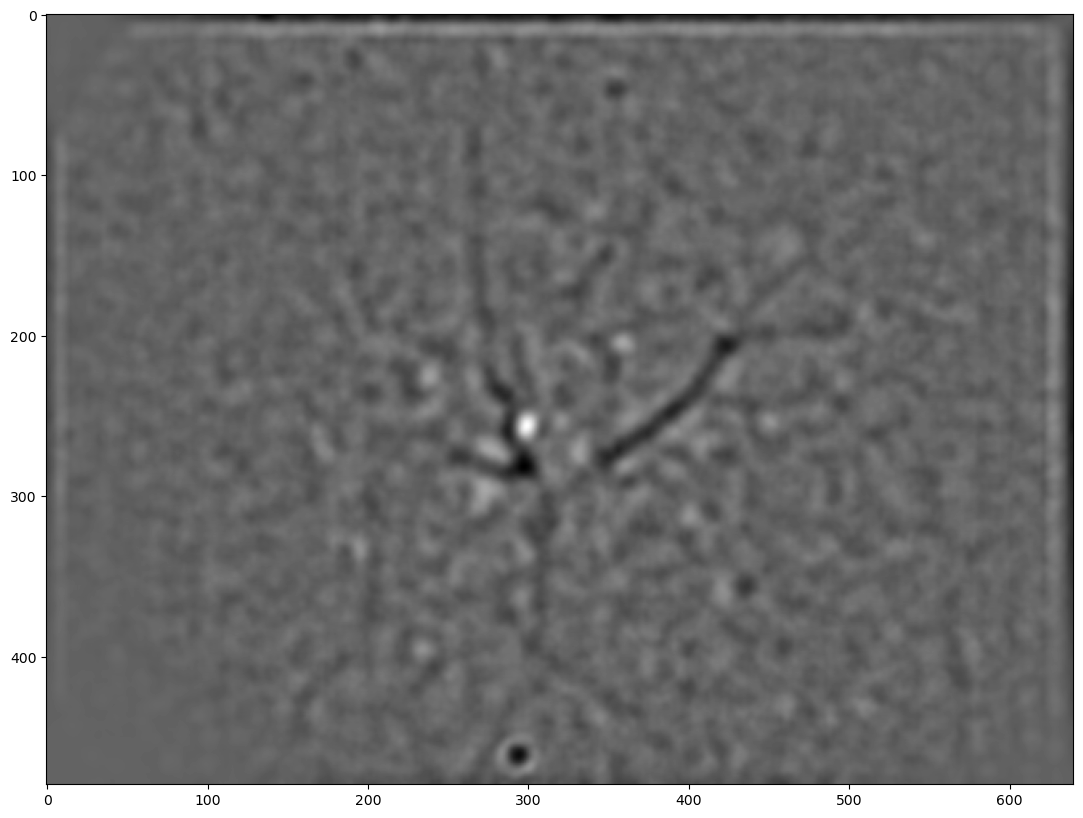

In [7]:
# load motion corrected movie
m_rig = cm.load(mc.mmap_file)
bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(int)
#%% visualize templates
plt.figure(figsize = (20,10))
plt.imshow(mc.total_template_rig, cmap = 'gray');

In [8]:
#%% inspect movie
m_rig.resize(1, 1, downsample_ratio).play(
    q_max=99.5, fr=30, magnification=2, bord_px = 0*bord_px_rig) # press q to exit

       32708 [movies.py:              resize():1023] [86997] reshaping along z


plot the shifts computed by rigid registration

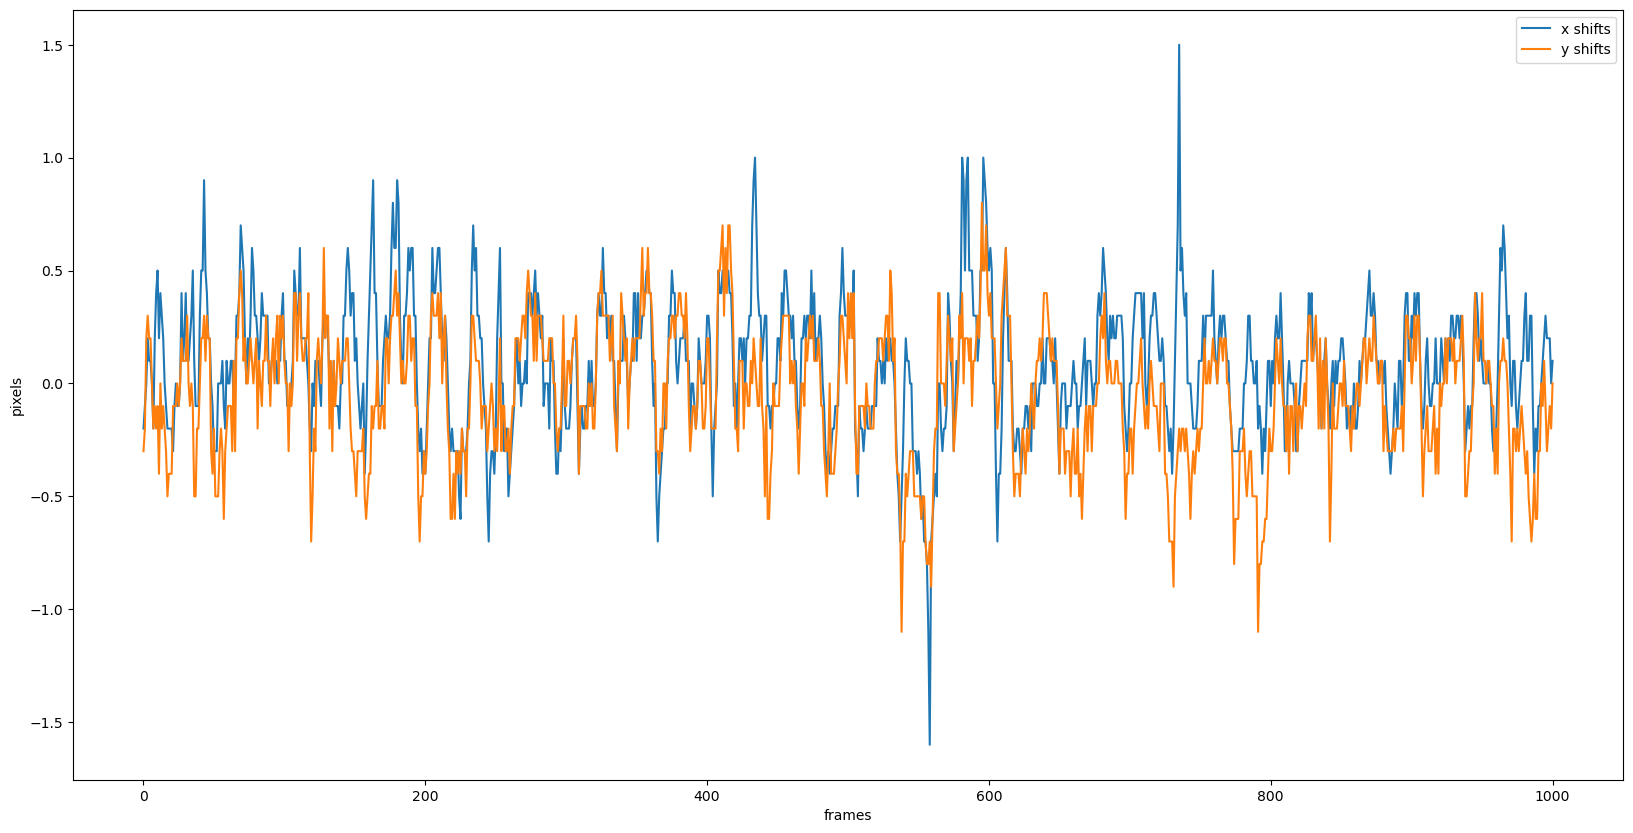

In [9]:
#%% plot rigid shifts
plt.close()
plt.figure(figsize = (20,10))
plt.plot(mc.shifts_rig)
plt.legend(['x shifts','y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels');

## Piecewise rigid registration
While rigid registration corrected for a lot of the movement, there is still non-uniform motion present in the registered file. To correct for that we can use piece-wise rigid registration **directly in the original file** by setting `mc.pw_rigid=True`. As before the registered file is saved in a memory mapped format in the location given by `mc.mmap_file`.

In [10]:
%%capture
#%% motion correct piecewise rigid
mc.pw_rigid = True  # turn the flag to True for pw-rigid motion correction
mc.template = mc.mmap_file  # use the template obtained before to save in computation (optional)

mc.motion_correct(save_movie=True, template=mc.total_template_rig)
m_els = cm.load(mc.fname_tot_els)
m_els.resize(1, 1, downsample_ratio).play(
    q_max=99.5, fr=30, magnification=2,bord_px = bord_px_rig)

       43781 [motion_correction.py:motion_correct_batch_pwrigid():2944] [86997] Adding to movie 3.4016125
       43781 [motion_correction.py:motion_correct_batch_pwrigid():2947] [86997] 0
       43781 [motion_correction.py:motion_correct_batch_pwrigid():2957] [86997] saving mmap of /Users/austinbrotman/Documents/lois-rotation/stability-preprocessing/data/miniscope2023-06-22T00_22_24_truncated.avi
       43783 [motion_correction.py:motion_correction_piecewise():3100] [86997] Number of Splits: 14
       43834 [motion_correction.py:motion_correction_piecewise():3134] [86997] Saving file as /Users/austinbrotman/Documents/lois-rotation/stability-preprocessing/data/miniscope2023-06-22T00_22_24_truncated_els__d1_480_d2_640_d3_1_order_F_frames_1001.mmap
       43834 [motion_correction.py:motion_correction_piecewise():3140] [86997] Extracting parameters for frames: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

Now concatenate all the movies (raw, rigid, and pw-rigid) for inspection

In [11]:
cm.concatenate([m_orig.resize(1, 1, downsample_ratio) - mc.min_mov*mc.nonneg_movie,
                m_rig.resize(1, 1, downsample_ratio), m_els.resize(
            1, 1, downsample_ratio)], axis=2).play(fr=25, q_max=99.5, magnification=2, bord_px=bord_px_rig)

       68157 [movies.py:              resize():1023] [86997] reshaping along z
       68411 [movies.py:              resize():1023] [86997] reshaping along z
       68946 [movies.py:              resize():1023] [86997] reshaping along z


From the movie we can see that pw-rigid registration corrected for the non uniform motion of the data. This was done by estimating different displacement vectors for the different patches in the FOV. This can be visualized by plotting all the computed shifts were a dispersion in the shifts in the y direction is apparent. In this case, the shifts along the two axes are stored in `mc.x_shifts_els` and `mc.y_shifts_els`, respectively.

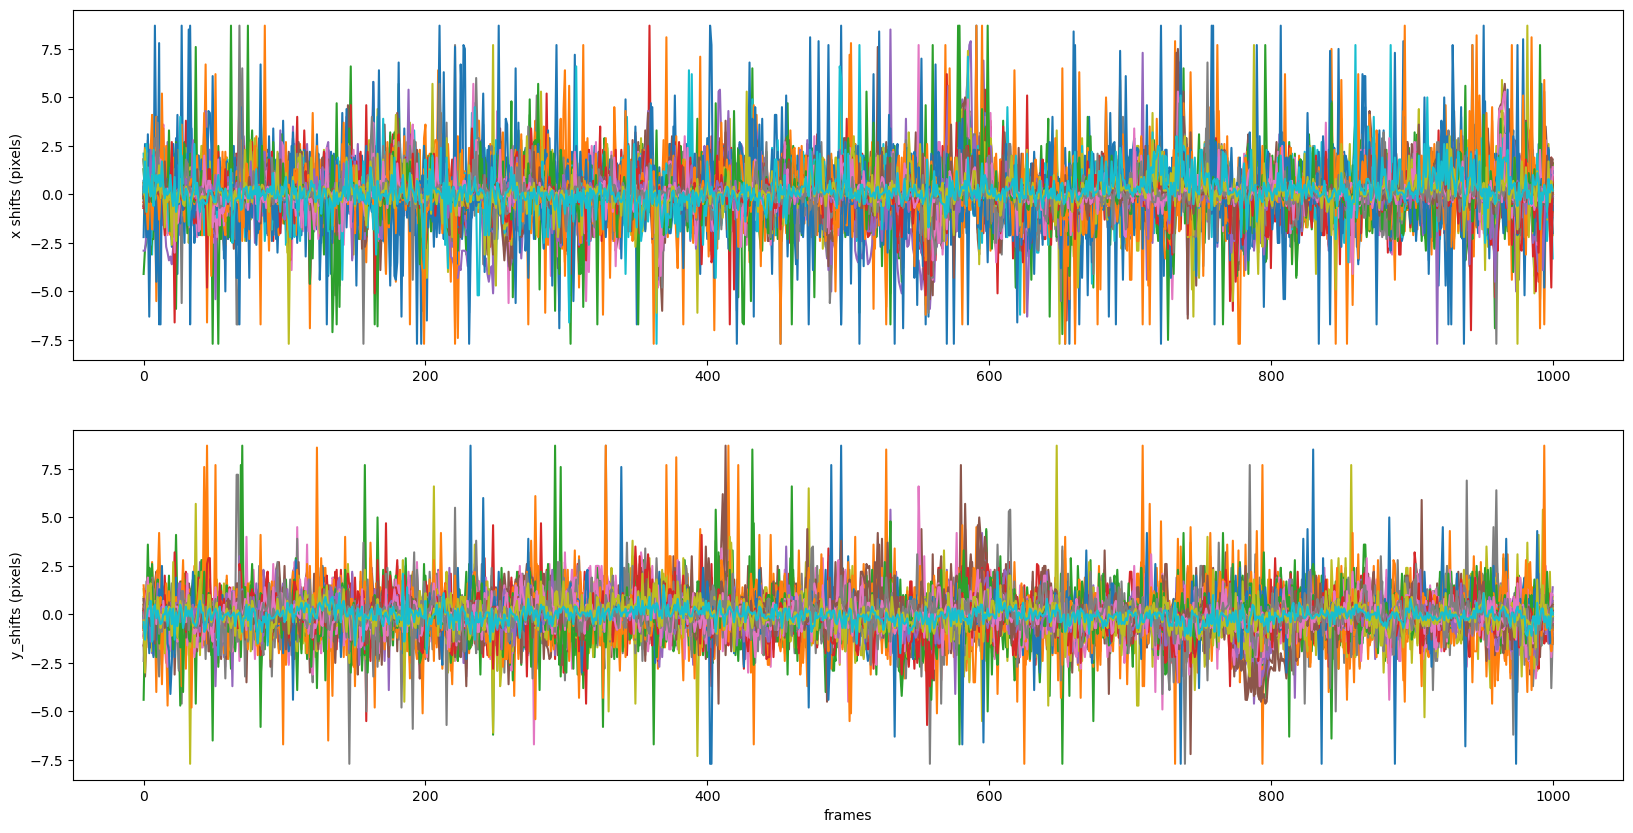

In [12]:
#%% visualize elastic shifts
plt.close()
plt.figure(figsize = (20,10))
plt.subplot(2, 1, 1)
plt.plot(mc.x_shifts_els)
plt.ylabel('x shifts (pixels)')
plt.subplot(2, 1, 2)
plt.plot(mc.y_shifts_els)
plt.ylabel('y_shifts (pixels)')
plt.xlabel('frames')
#%% compute borders to exclude
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(int)

The improvement in performance can also be seen by a more crisp summary statistic image. Below we plot the correlation images for the three datasets.

/opt/homebrew/Caskroom/miniforge/base/envs/stability-preprocessing/lib/python3.11/site-packages/caiman/summary_images.py:209: RuntimeWarning: invalid value encountered in divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)


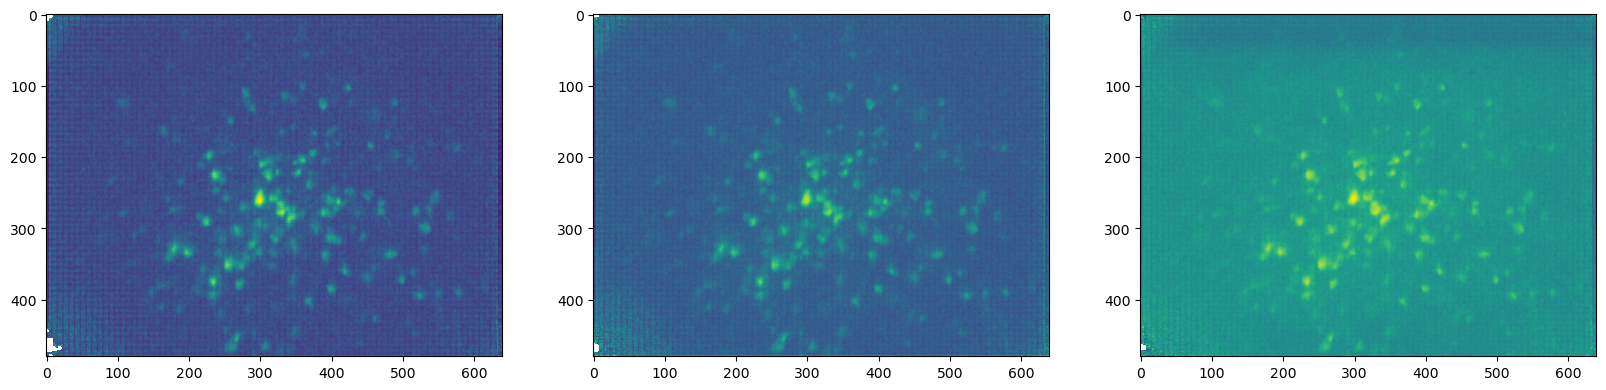

In [13]:
plt.figure(figsize = (20,10))
plt.subplot(1,3,1); plt.imshow(m_orig.local_correlations(eight_neighbours=True, swap_dim=False))
plt.subplot(1,3,2); plt.imshow(m_rig.local_correlations(eight_neighbours=True, swap_dim=False))
plt.subplot(1,3,3); plt.imshow(m_els.local_correlations(eight_neighbours=True, swap_dim=False))

In [14]:
cm.stop_server(dview=dview) # stop the server

       87157 [cluster.py:         stop_server():177] [86997] stop_cluster(): done


## Quality assessment 

Apart from inspection, the performance of the registration methods can be quantified using several measures. Below we compute measures such as correlation of each frame with mean, crispness of summary image, and residual optical flow for all three cases. For more info see [[1]](#normcorre). Note that computation of the residual optical flow can be computationally intensive.

In [15]:
%%capture
#% compute metrics for the results (TAKES TIME!!)
final_size = np.subtract(mc.total_template_els.shape, 2 * bord_px_els) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF

tmpl_orig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    fnames[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_rig[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_els[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

       87232 [movies.py:                load():1436] [86997] No accelerated colorspace conversion found from yuv420p to bgr24.
       87783 [motion_correction.py:compute_metrics_motion_correction():2621] [86997] [9, -9, 9, -9]
       87882 [motion_correction.py:compute_metrics_motion_correction():2628] [86997] Local correlations..
       89008 [motion_correction.py:compute_metrics_motion_correction():2630] [86997] (1001, 462, 622)
       90572 [motion_correction.py:compute_metrics_motion_correction():2636] [86997] Compute Smoothness.. 
       90844 [motion_correction.py:compute_metrics_motion_correction():2642] [86997] Compute correlations.. 
       90844 [motion_correction.py:compute_metrics_motion_correction():2649] [86997] 0
       91033 [motion_correction.py:compute_metrics_motion_correction():2649] [86997] 100
       91218 [motion_correction.py:compute_metrics_motion_correction():2649] [86997] 200
       91402 [motion_correction.py:compute_metrics_motion_correction():2649] [86997]

Plot correlation with mean frame for each dataset

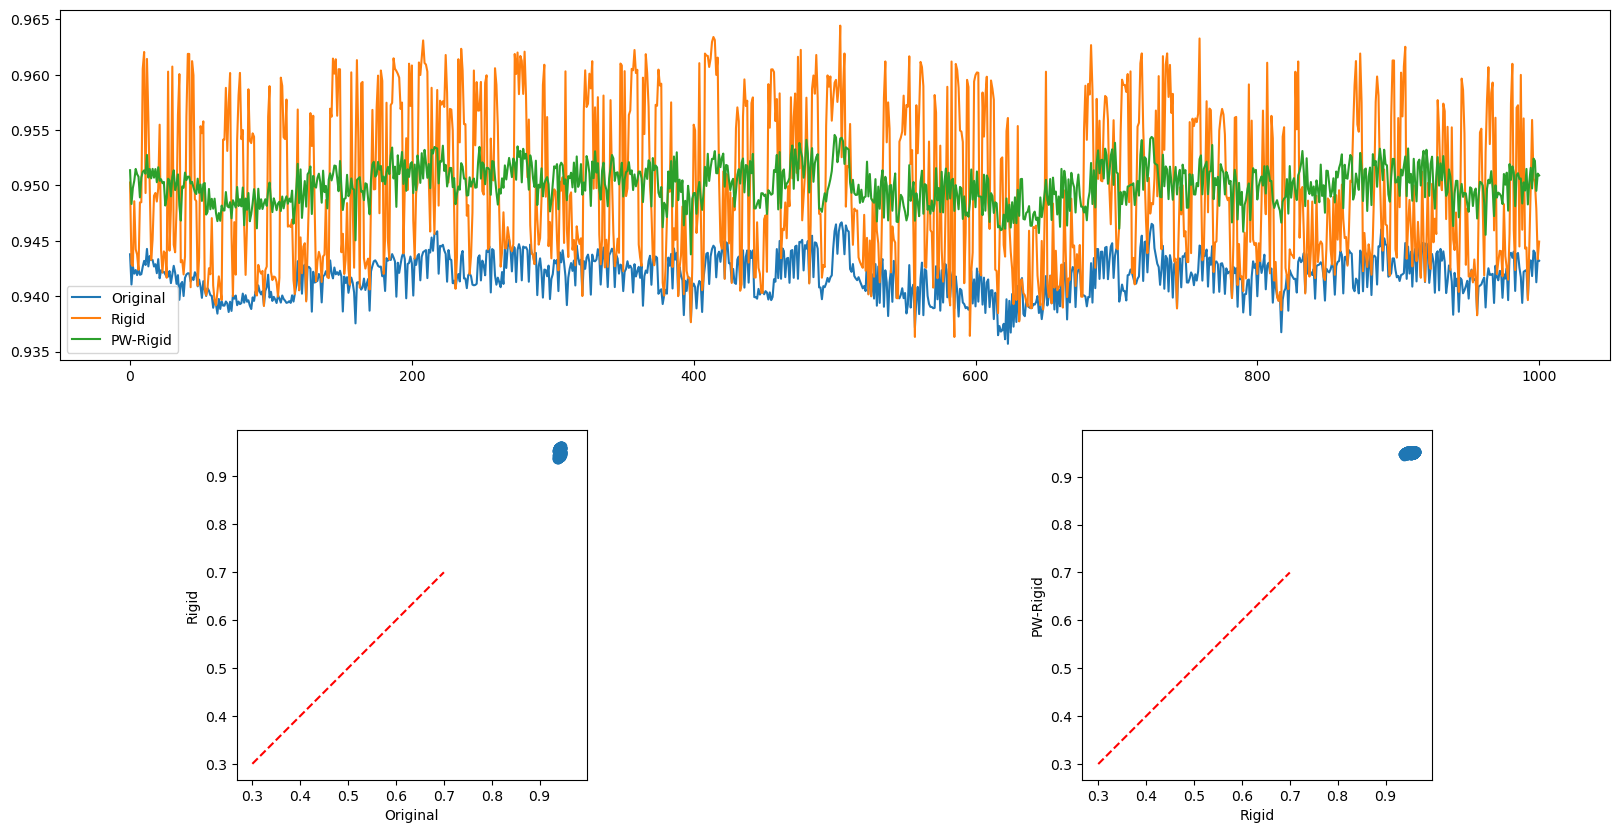

In [16]:
plt.figure(figsize = (20,10))
plt.subplot(211); plt.plot(correlations_orig); plt.plot(correlations_rig); plt.plot(correlations_els)
plt.legend(['Original','Rigid','PW-Rigid'])
plt.subplot(223); plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original'); 
plt.ylabel('Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');
plt.subplot(224); plt.scatter(correlations_rig, correlations_els); plt.xlabel('Rigid'); 
plt.ylabel('PW-Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');


In [17]:
# print crispness values
print('Crispness original: ' + str(int(crispness_orig)))
print('Crispness rigid: ' + str(int(crispness_rig)))
print('Crispness elastic: ' + str(int(crispness_els)))

Crispness original: 1086
Crispness rigid: 935
Crispness elastic: 764


      139444 [movies.py:                load():1573] [86997] mmap


KeysView(NpzFile '/Users/austinbrotman/Documents/lois-rotation/stability-preprocessing/data/miniscope2023-06-22T00_22_24_truncated_els__d1_480_d2_640_d3_1_order_F_frames_1001_metrics.npz' with keys: flows, norms, correlations, smoothness, tmpl...)
/Users/austinbrotman/Documents/lois-rotation/stability-preprocessing/data/miniscope2023-06-22T00_22_24_truncated_els__d1_480_d2_640_d3_1_order_F_frames_1001_metrics.npz
191.4189+/-80.08026 ; 764.174 ; 12.693666095219163
Loading data with base /Users/austinbrotman/Documents/lois-rotation/stability-preprocessing/data/miniscope2023-06-22T00_22_24_truncated_els__d1_480_d2_640_d3_1_order_F_frames_1001


      139722 [colorbar.py:_get_ticker_locator_formatter():859] [86997] locator: <matplotlib.ticker.AutoLocator object at 0x297ee17d0>
      139731 [movies.py:                load():1573] [86997] mmap


KeysView(NpzFile '/Users/austinbrotman/Documents/lois-rotation/stability-preprocessing/data/miniscope2023-06-22T00_22_24_truncated_rig__d1_480_d2_640_d3_1_order_F_frames_1001_metrics.npz' with keys: flows, norms, correlations, smoothness, tmpl...)
/Users/austinbrotman/Documents/lois-rotation/stability-preprocessing/data/miniscope2023-06-22T00_22_24_truncated_rig__d1_480_d2_640_d3_1_order_F_frames_1001_metrics.npz
151.94325+/-77.89842 ; 935.496 ; 12.890393916172213
Loading data with base /Users/austinbrotman/Documents/lois-rotation/stability-preprocessing/data/miniscope2023-06-22T00_22_24_truncated_rig__d1_480_d2_640_d3_1_order_F_frames_1001


      140022 [colorbar.py:_get_ticker_locator_formatter():859] [86997] locator: <matplotlib.ticker.AutoLocator object at 0x2956ed750>
      140026 [movies.py:                load():1589] [86997] File request:[/Users/austinbrotman/Documents/lois-rotation/stability-preprocessing/data/miniscope2023-06-22T00_22_24_truncated.mmap] not found!
      140040 [movies.py:                load():1436] [86997] No accelerated colorspace conversion found from yuv420p to bgr24.


KeysView(NpzFile '/Users/austinbrotman/Documents/lois-rotation/stability-preprocessing/data/miniscope2023-06-22T00_22_24_truncated_metrics.npz' with keys: flows, norms, correlations, smoothness, tmpl...)
/Users/austinbrotman/Documents/lois-rotation/stability-preprocessing/data/miniscope2023-06-22T00_22_24_truncated_metrics.npz
41.994293+/-6.598319 ; 1086.3589 ; nan
Loading data with base /Users/austinbrotman/Documents/lois-rotation/stability-preprocessing/data/miniscope2023-06-22T00_22_24_truncated


      140782 [colorbar.py:_get_ticker_locator_formatter():859] [86997] locator: <matplotlib.ticker.AutoLocator object at 0x295787dd0>
      140788 [font_manager.py:    _findfont_cached():1411] [86997] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
      140788 [font_manager.py:    _findfont_cached():1423] [86997] findfont: score(FontEntry(fname='/opt/homebrew/Caskroom/miniforge/base/envs/stability-preprocessing/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
      140788 [font_manager.py:    _findfont_cached():1423] [86997] findfont: score(FontEntry(fname='/opt/homebrew/Caskroom/miniforge/base/envs/stability-preprocessing/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='norma

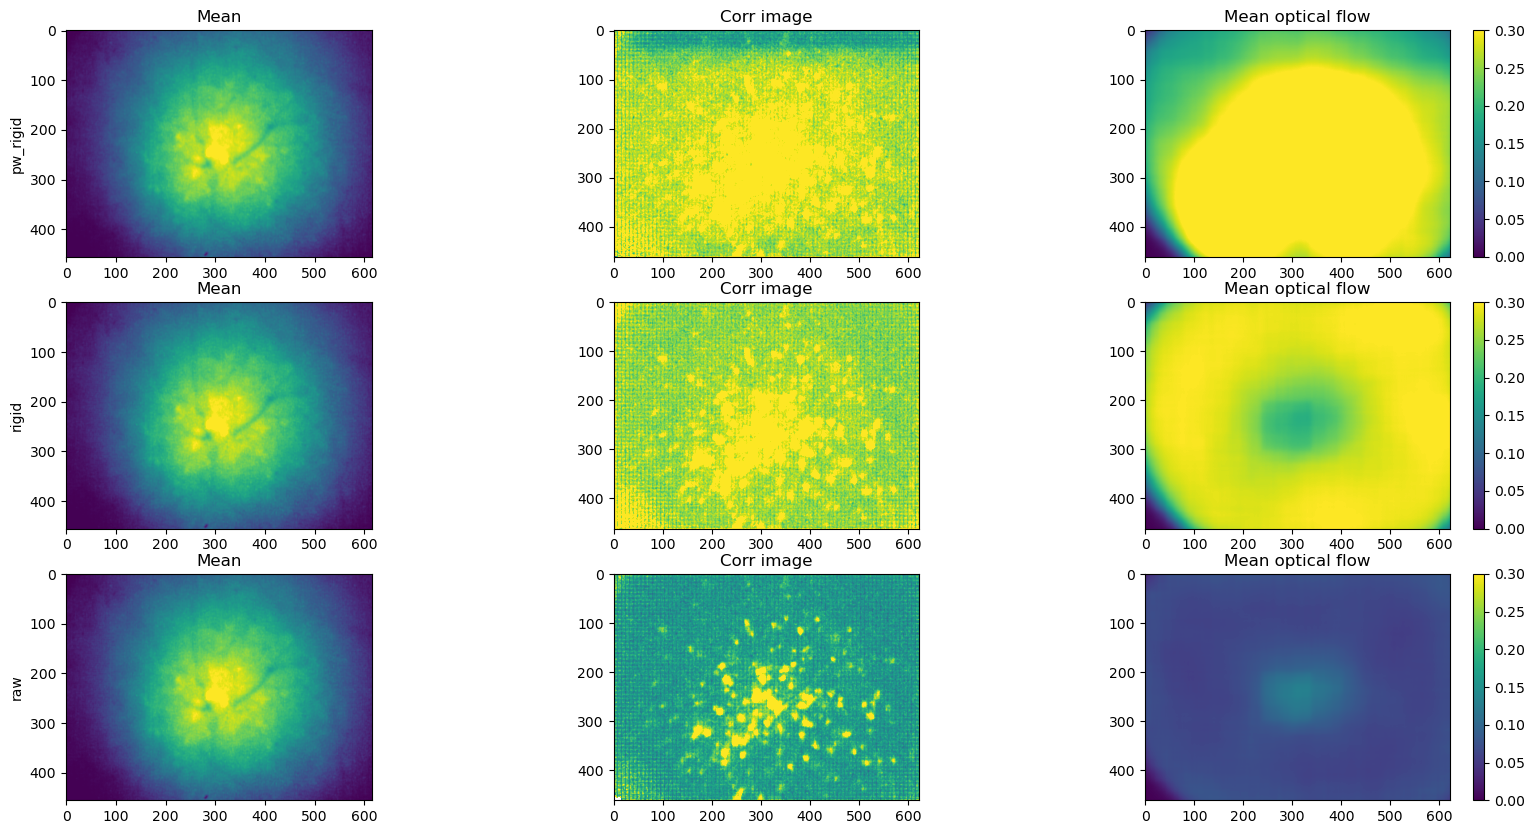

In [18]:
#%% plot the results of Residual Optical Flow
fls = [cm.paths.fname_derived_presuffix(mc.fname_tot_els[0], 'metrics', swapsuffix='npz'),
       cm.paths.fname_derived_presuffix(mc.fname_tot_rig[0], 'metrics', swapsuffix='npz'),
       cm.paths.fname_derived_presuffix(mc.fname[0],         'metrics', swapsuffix='npz'),
      ]

plt.figure(figsize = (20,10))
for cnt, fl, metr in zip(range(len(fls)), fls, ['pw_rigid','rigid','raw']):
    with np.load(fl) as ld:
        print(ld.keys())
        print(fl)
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
        
        plt.subplot(len(fls), 3, 1 + 3 * cnt)
        plt.ylabel(metr)
        print(f"Loading data with base {fl[:-12]}")
        try:
            mean_img = np.mean(
            cm.load(fl[:-12] + '.mmap'), 0)[12:-12, 12:-12]
        except:
            try:
                mean_img = np.mean(
                    cm.load(fl[:-12] + '.avi'), 0)[12:-12, 12:-12]
            except:
                mean_img = np.mean(
                    cm.load(fl[:-12] + 'hdf5'), 0)[12:-12, 12:-12]
                    
        lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
        plt.imshow(mean_img, vmin=lq, vmax=hq)
        plt.title('Mean')
        plt.subplot(len(fls), 3, 3 * cnt + 2)
        plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
        plt.title('Corr image')
        plt.subplot(len(fls), 3, 3 * cnt + 3)
        flows = ld['flows']
        plt.imshow(np.mean(
        np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
        plt.colorbar()
        plt.title('Mean optical flow');  